# Kaggle APTOS 2019 Challenge

APTOS 2019 is a challenge hosted by Kaggle where the goal is to classify fundus (eye retina) images of diabetic rethinopatic patients according to the severity of their disease on a scale 0 (minimum severity) to 4 (maximum severity).

This notebook illustrates the model I submitted which achieved a final QWK (Quadratic Weighted Kappa) score of 0.9 (maximum score being 1).

* model: EfficientNet B5
* no cropping or equalization
* augmentation: flipud, fliplr, zoom, rotation
* no TTA (worse results)

### Load libraries

In [7]:
import os
import sys
sys.path.append(os.path.abspath('../input/efficientnetkeras/efficientnet-master')) # from https://github.com/qubvel/efficientnet

import cv2
import efficientnet.keras as efn
import json
from keras.activations import elu
from keras.callbacks import Callback
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
import tensorflow as tf
from tqdm import tqdm

### Set parameters

In [8]:
batch_size = 32
EN_size = 224
seed = 1990

### Set random seed

In [9]:
random.seed(seed)
tf.set_random_seed(seed)

### Load data

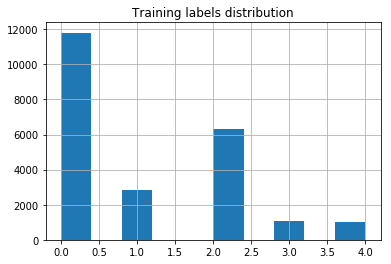

In [10]:
labels_15 = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
labels_15.rename(columns={"image": "id_code", "level": "diagnosis"}, inplace=True)
labels_15['path'] = '../input/diabetic-retinopathy-resized/resized_train/resized_train' + '/' + labels_15['id_code'] + '.jpeg'

idx = labels_15[labels_15['diagnosis']==0].index.to_list()
idx = random.sample(idx, k=len(idx)-10000) # cut class 0 examples for more balance and to reduce training time
labels_15.drop(idx, inplace=True)

labels_19 = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
labels_19['path'] = '../input/aptos2019-blindness-detection/train_images' + '/' + labels_19['id_code'] + '.png'

train_df = pd.concat([labels_15, labels_19])

train_df['diagnosis'].hist()
plt.title('Training labels distribution')
train_df['diagnosis'].value_counts()

x = train_df[['path']]
y = train_df['diagnosis']

### Function to open and resize images

In [11]:
def preprocess_image(path):
    img = Image.open(path)
    img = img.resize((EN_size, EN_size), resample=Image.LANCZOS)
    return img

### Split dataset

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, stratify=y, random_state=seed)

In [13]:
x_val_arr = np.empty((x_val.shape[0], EN_size, EN_size, 3), dtype=np.uint8)

for i, row in tqdm(x_val.reset_index().iterrows(), total=len(x_val)):
    try:
        x_val_arr[i, :, :, :] = preprocess_image(row['path'])
    except:
        pass

100%|██████████| 3447/3447 [02:16<00:00, 25.31it/s]


In [14]:
train_df = pd.DataFrame(pd.concat([x_train, pd.DataFrame(y_train)], axis=1), columns=['path', 'diagnosis'])

### Create data generator

In [15]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.25,
        rotation_range=180,
        fill_mode='constant',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=.05,
        height_shift_range=.05
    )

train_generator = create_datagen().flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='diagnosis',
    target_size=(EN_size, EN_size),
    class_mode='other',
    batch_size=batch_size,
    seed=seed,
    interpolation="lanczos",
    drop_duplicates=True
    )

Found 19531 validated image filenames.


### Create Keras callback for QWK score

In [16]:
class QWK(Callback):

    def on_train_begin(self, logs={}):
        self.val_kappas = []
        
    def on_epoch_end(self, epoch, logs={}):
        x_val, y_val = self.validation_data[:2]
        
        y_pred = self.model.predict(x_val)
        
        coeff = [0.5, 1.5, 2.5, 3.5]

        for i, pred in enumerate(y_pred):
            if pred < coeff[0]:
                y_pred[i] = 0
            elif pred >= coeff[0] and pred < coeff[1]:
                y_pred[i] = 1
            elif pred >= coeff[1] and pred < coeff[2]:
                y_pred[i] = 2
            elif pred >= coeff[2] and pred < coeff[3]:
                y_pred[i] = 3
            else:
                y_pred[i] = 4

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

### Model: EfficientNet B5

In [17]:
effnet = efn.EfficientNetB5(
    weights=None,
    include_top=False,
    input_shape=(EN_size, EN_size, 3)
)

effnet.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

In [18]:
def build_model():
    
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation="elu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse', optimizer=Adam(lr=1e-4), metrics=['mse'])
    
    return model

In [19]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 28,523,771
Trainable params: 28,351,035
Non-trainable params: 172,736
_________________________________________________________________


### Training and evaluation of the model

In [20]:
qwk = QWK()

history = model.fit_generator(
    train_generator,
    steps_per_epoch=x_train.shape[0] / batch_size,
    epochs=15,
    validation_data=(x_val_arr, y_val),
    callbacks=[qwk]
)

Epoch 1/15
611/610 [==============================] - 1235s 2s/step - loss: 1.0948 - mean_squared_error: 1.0948 - val_loss: 0.7673 - val_mean_squared_error: 0.7673
val_kappa: 0.6015
Validation Kappa has improved. Saving model.
Epoch 2/15
345/610 [===============>..............] - ETA: 7:55 - loss: 0.8334 - mean_squared_error: 0.8334

KeyboardInterrupt: 

In [21]:
model.load_weights('model.h5')

In [22]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot

plt.plot(qwk.val_kappas)

NameError: name 'history' is not defined

### Submission

In [23]:
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [24]:
N = test_df.shape[0]
x_test = np.empty((N, EN_size, EN_size, 3), dtype=np.uint8)

for i, img_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(f'../input/aptos2019-blindness-detection/test_images/{img_id}.png')

  6%|▌         | 114/1928 [00:05<01:39, 18.20it/s]


KeyboardInterrupt: 

In [ ]:
y_test = model.predict(x_test)

coeff = [0.5, 1.5, 2.5, 3.5]

for i, pred in enumerate(y_test):
    if pred < coeff[0]:
        y_test[i] = 0
    elif pred >= coeff[0] and pred < coeff[1]:
        y_test[i] = 1
    elif pred >= coeff[1] and pred < coeff[2]:
        y_test[i] = 2
    elif pred >= coeff[2] and pred < coeff[3]:
        y_test[i] = 3
    else:
        y_test[i] = 4

test_df['diagnosis'] = y_test.astype(int)
test_df.to_csv('submission.csv', index=False)

test_df['diagnosis'].hist()